# Kalman Filters


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

In [2]:
from filters import bayes, stats
from models import const_vel
from plots import plot_bayes, plot_common, plot_kf
from simulators import datagen, linear

## One Dimension


N(μ=9.775, σ²=0.141)


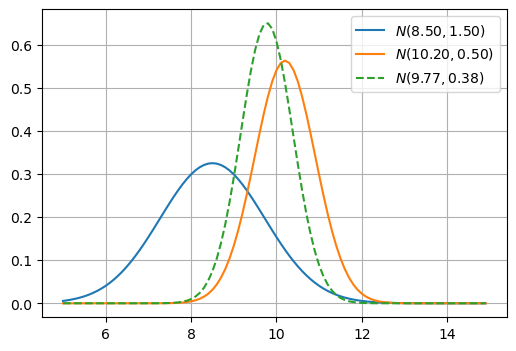

In [3]:
z1 = stats.gaussian(8.5, 1.5)
z2 = stats.gaussian(10.2, 0.5)
zz = stats.gaussian_product(z1, z2)
print(zz)

xs = np.arange(5, 15, 0.1)

_, ax = plt.subplots(figsize=(6, 4))
plot_bayes.plot_gaussian_product(ax, xs, z1, z2)

# plt.savefig("../images/gaussian-prod.png")

In [4]:
np.random.seed(13)

Q = 1.0
R = 2.0
velocity = 1
dt = 1.0

model = stats.gaussian(velocity * dt, Q)
x0 = stats.gaussian(0.0, 20.0**2)

dog = linear.DogSimulation(x0=x0.mean, model_mean=model.mean, Q=model.var, R=R)
_, zs = dog.simulate(num=10)

priors, xs, ps = bayes.prior_estimate(x0, model, zs, R, show_steps=True)

  1.000  401.000	13.398	 13.336   1.990
 final estimate:         24.440
 actual final value:     23.692


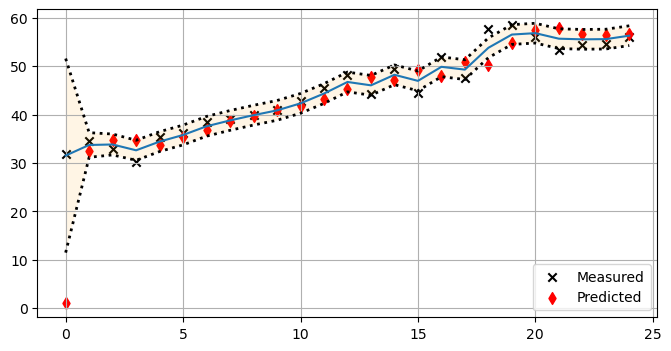

In [5]:
Q = 2.0
R = 4.5
model = stats.gaussian(1.0, Q)

dog = linear.DogSimulation(x0.mean, model.mean, Q, R)
xs, zs = dog.simulate(num=25)

priors, xs, ps = bayes.prior_estimate(x0, model, zs, R)

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, zs)
plot_common.plot_preds(ax, priors[:, 0], kind="scatter")
plot_kf.plot_kf(ax, xs[:, 0], var=priors[:, 1], band_color="orange")

Variance converges to 0.017


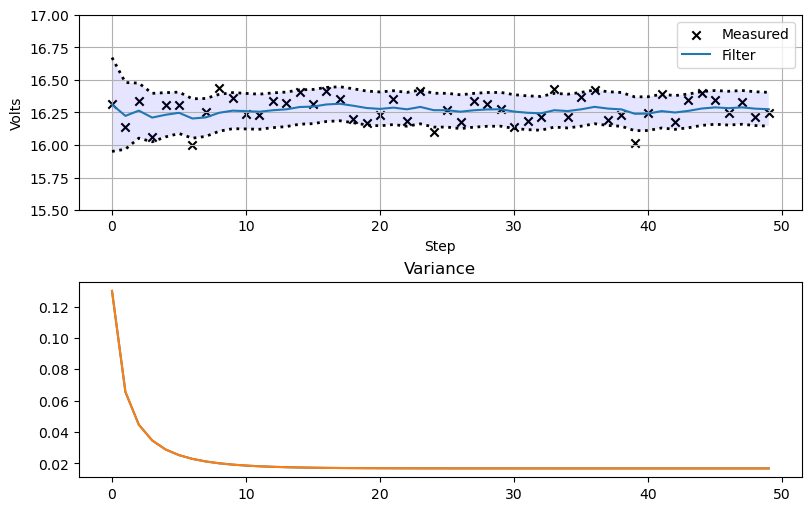

In [6]:
actual_voltage, voltage_std = 16.3, 0.13
zs = [datagen.jitterfy(actual_voltage, voltage_std) for _ in range(50)]

Q = 0.05**2
R = voltage_std
model = stats.gaussian(0.0, Q)

x = stats.gaussian(25.0, 1000.0)
priors, xs, ps = bayes.prior_estimate(x0, model, zs, R)
xmeans, pmeans = xs[:, 0], ps[:, 0]

_, axes = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)

plot_common.plot_zs(axes[0], zs)
plot_kf.plot_kf(axes[0], xmeans, var=pmeans)
axes[0].set(xlabel="Step", ylabel="Volts", ylim=(15.5, 17))
axes[0].legend()
axes[1].plot(ps)
axes[1].set(title="Variance")

print(f"Variance converges to {pmeans[-1]:.3f}")

### Incorrect Model Variance


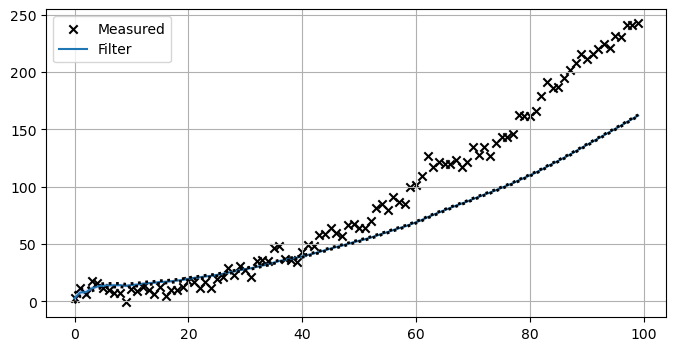

In [7]:
np.random.seed(42)

R = 20.0
Q = 0.01
model = stats.gaussian(1.0, Q)

pos = stats.gaussian(0.0, 500.0)
dog = linear.DogSimulation(pos.mean, 1, R, Q * 1000)
zs = [dog.move_and_sense(acc=0.04) for _ in range(100)]
priors, xs, ps = bayes.prior_estimate(pos, model, zs, R)
xmeans, pmeans = xs[:, 0], ps[:, 0]

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, zs)
plot_kf.plot_kf(ax, xmeans, var=pmeans)
ax.legend()

### Bad Initial Estimate


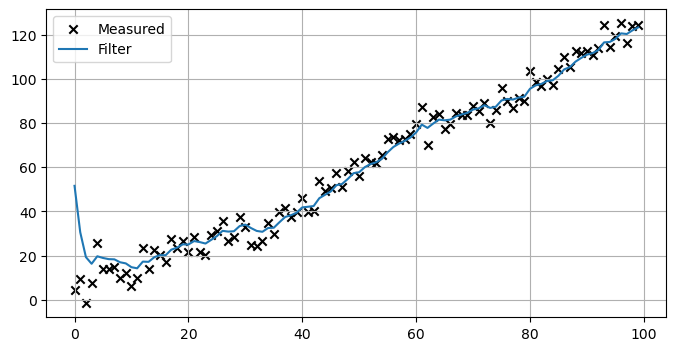

In [8]:
R2 = 5.0**2
Q2 = 2.0
model2 = stats.gaussian(1.0, Q2)

dog2 = linear.DogSimulation(0, 1, Q2, R2)
zs2 = [dog2.move_and_sense() for _ in range(100)]
pos2 = stats.gaussian(1000.0, 500.0)
priors2, xs2, ps2 = bayes.prior_estimate(pos2, model2, zs2, R2)
xmeans, pmeans = xs2[:, 0], ps2[:, 0]

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, zs2)
plot_kf.plot_kf(ax, xmeans)
ax.legend()

### Large Noise and Bad Initial Estimate


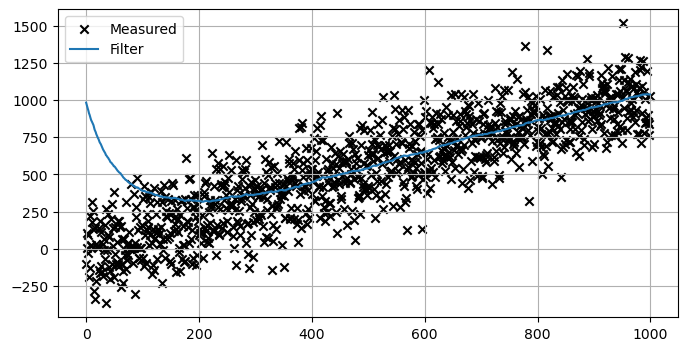

In [9]:
R_ = 30000.0
Q_ = 2.0
model_ = stats.gaussian(1.0, Q_)

dog_ = linear.DogSimulation(0, 1, Q_, R_)
zs_ = [dog_.move_and_sense() for _ in range(1000)]
pos_ = stats.gaussian(1000.0, 500.0)
priors_, xs_, ps_ = bayes.prior_estimate(pos_, model_, zs_, R_)
xmeans, pmeans = xs_[:, 0], ps_[:, 0]

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, zs_)
plot_kf.plot_kf(ax, xmeans)
ax.legend()

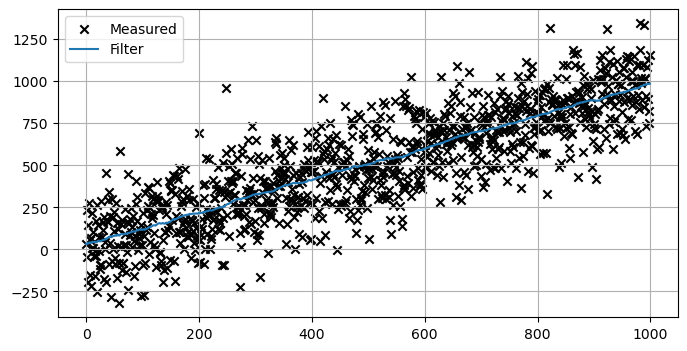

In [10]:
R3 = 30000.0
Q3 = 2.0
model3 = stats.gaussian(1.0, Q3)

dog3 = linear.DogSimulation(0, 1, Q3, R3)
zs3 = [dog3.move_and_sense() for _ in range(1000)]
pos3 = stats.gaussian(zs3[0], 500.0)
priors3, xs3, ps3 = bayes.prior_estimate(pos3, model3, zs3, R3)
xmeans, pmeans = xs3[:, 0], ps3[:, 0]

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, zs3)
plot_kf.plot_kf(ax, xmeans)
ax.legend()

### Nonlinear Systems


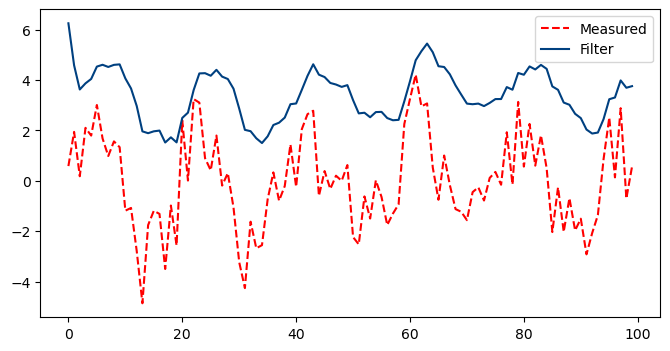

In [11]:
Q = 2.0
R = 30.0
pos = stats.gaussian(100.0, 500.0)
model = stats.gaussian(1.0, Q)

zs, ps = [], []
for i in range(100):
    pos = stats.gaussian_sum(pos, model)
    z = np.sin(i / 3.0) * 2 + random.randn() * 1.2
    likelihood = stats.gaussian(z, R)
    pos = stats.gaussian_product(pos, likelihood)
    zs.append(z)
    ps.append(pos.mean)


_, ax = plt.subplots(figsize=(8, 4))

ax.plot(zs, c="r", linestyle="--", label="Measured")
ax.plot(ps, c="#004080", label="Filter")
ax.legend()

## Multi Dimension


In [12]:
dt = 0.1
kf_cv = const_vel.KFCV2d(P=500, R=5, Q=0.1, dt=dt)

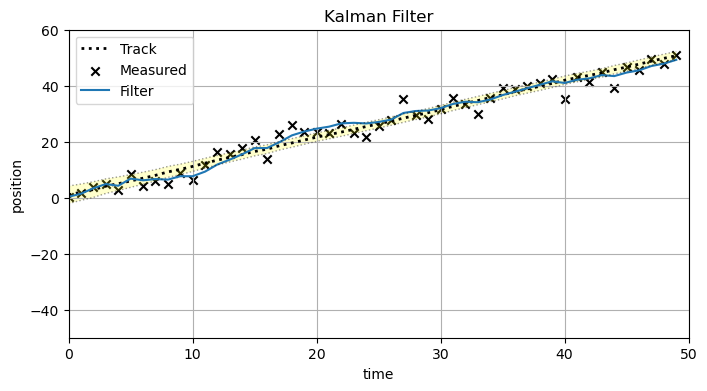

In [13]:
def run(zs, x0=(0.0, 0.0), P=500, R=0, Q=0, dt=1.0, **kwargs):
    kf = const_vel.KFCV2d(R=R, P=P, Q=Q, x=x0, dt=dt)
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    return np.array(xs), np.array(cov)


R = 10
Q = 0.01

track, zs = datagen.gen_jittered_vel(x0=0, dx=1, num=50, R=R, Q=Q)

_, ax = plt.subplots(figsize=(8, 4))

P = np.diag([500.0, 49.0])
Ms, Ps = run(zs, count=50, R=10, Q=0.01, P=P)
plot_kf.plot_kf_with_cov(ax, Ms[:, 0], Ps, track, zs)

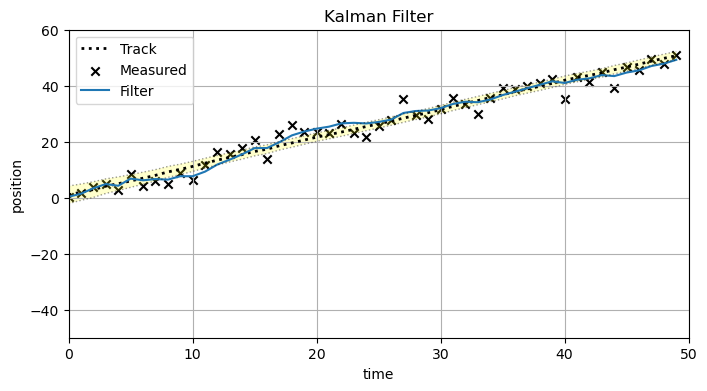

In [14]:
dt = 1.0
R = 10
Q = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])
H = np.array([[1.0, 0.0]])
R = np.array([[R]])
# Q = discretizer.Q_discrete_white_noise(dim=2, dt=dt, var=Q)

track, zs = datagen.gen_jittered_vel(x0=0, dx=1, num=50, R=R, Q=Q)
Ms, Ps = run(zs, count=50, R=R, Q=Q, P=P)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_with_cov(ax, Ms[:, 0], Ps, track, zs)

### Varying Q


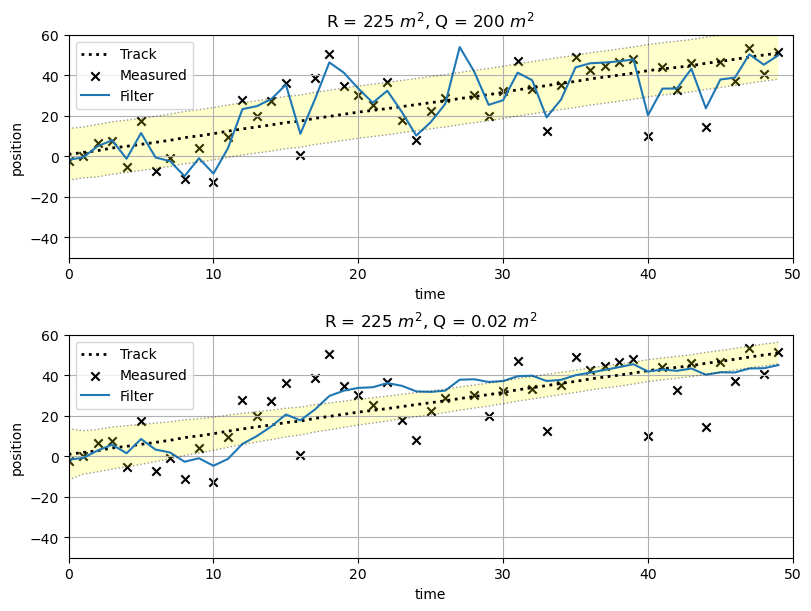

In [15]:
track, zs = datagen.gen_jittered_vel(x0=0, dx=1, num=50, R=225, Q=0.02)

Rs = [225, 225]
Qs = [200, 0.02]

_, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

for R, Q, ax in zip(Rs, Qs, axes.flatten()):
    Ms, Ps = run(track=track, zs=zs, R=R, Q=Q, P=P)
    plot_kf.plot_kf_with_cov(
        ax, Ms[:, 0], Ps, track, zs, title=f"R = {R} $m^2$, Q = {Q} $m^2$"
    )

# plt.savefig("../images/kalman-q.png")

### Varying P


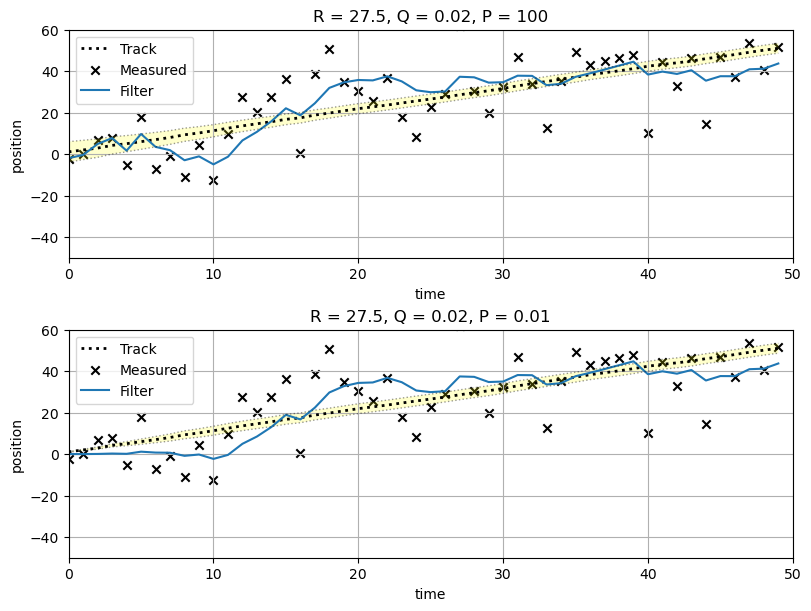

In [16]:
R = 27.5
Q = 0.02
Ps = [100, 0.01]

_, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

for P, ax in zip(Ps, axes.flatten()):
    Ms, Ps = run(track=track, zs=zs, R=R, Q=Q, P=P, x0=np.array([100.0, 0.0]))
    plot_kf.plot_kf_with_cov(
        ax, Ms[:, 0], Ps, track, zs, title=f"R = {R}, Q = {Q}, P = {P}"
    )

# filter_plot.plot_cov2d(Ps)
# plt.savefig("../images/kalman-p.png")

### Varying R


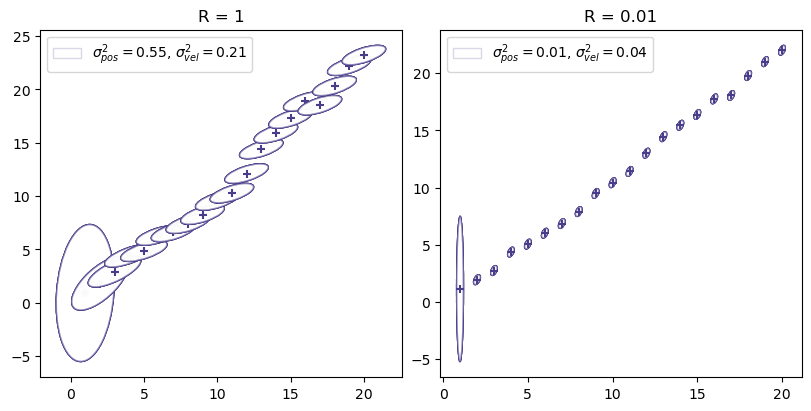

In [17]:
Rs = [1, 0.01]
Qs = [0.1, 0.1]
P = 20
num = 20

_, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

for R, Q, ax in zip(Rs, Qs, axes.flatten()):
    track, zs = datagen.gen_jittered_vel(x0=0, dx=1, num=num, R=R, Q=Q)
    Ms, Ps = run(track=track, zs=zs, R=R, Q=Q, P=P, x0=np.array([0.0, 0.0]))
    p = plot_common.plot_track_ellipses(ax, num, zs, Ms[:, 0], Ps, title=f"R = {R}")
    ax.legend(
        handles=None,
        labels=[
            "$σ^2_{pos} = $" + f"{p[0, 0]:.2f}, " + "$σ^2_{vel} = $" + f"{p[1, 1]:.2f}"
        ],
    )

# plt.savefig("../images/kalman-r.png")